## Partie 2: Capital Asset Pricing Model (CAPM)

## Le Capital Asset Pricing Model (CAPM)

Reférences:
- Sharpe, W. F. (1964). Capital asset prices: A theory of market equilibrium under conditions of risk. The journal of finance, 19(3), 425-442.
- Lintner, J. (1975). The valuation of risk assets and the selection of risky investments in stock portfolios and capital budgets. In Stochastic Optimization Models in Finance (pp. 131-155).
- Mossin, J. (1966). Equilibrium in a capital asset market. Econometrica: Journal of the econometric society, 768-783.

Problématique fondamentale : s'il existe un seul portefeuille optimal, que se passe-t-il lorsque tous les investisseurs investissent uniquement dans celui-ci ?

Suppositions du CAPM :

1] En termes de comportement individuel :
  - Les investisseurs sont tradionnels et optimisent le rendement attendu en fonction du risque comme vu en partie 1. ("Mean-variance optimizers")
  - Une seule période temporelle (décision, conséquence).
  - Les investisseurs disposent des mêmes inputs en termes d'espérance de rendement et de risque: ils ont la même information et des mêmes attentes (*homogeneous expectations*)

  
2] En termes de structure du marché:
  - Tous les actifs sont disponibles à l'investissement et échangés sur des marchés publics.
  - Les investisseurs peuvent prêter ou emprunter de l'argent à un taux fixe (taux de l'actif sans risque), et ils peuvent prendre des positions à découvert sur (shorter) des actifs.
  - Pas de taxe ni de coûts de transaction.

Considérons l'aggrégation de tous les portefeuilles des investisseurs. Les emprunts et les prêts s'annulent, et l'on peut représenter la richesse totale de l'économie à travers le portefeuille de marché. Ce portefeuille dispose d'un vecteur de poids, qui est la proportion de la richesse totale ventilée dans les différentes actions.

Si tous les portefeuilles (des investisseurs) sont le même portefeuille optimal, alors le portefeuille de marché disposera des mêmes poids que le portefeuille optimal.

Exemple : Si tous les investisseurs ont placé 1% de leur richesse dans l'actif A, alors 1% de la richesse totale est investie dans l'actif A : le portefeuille du marché dispose donc d'un poids de 1% pour l'actif A.

Si un actif ne fait pas partie du portefeuille optimal, alors aucun investisseur ne va acquérir de titre. Le prix va plonger, jusqu'à atteindre un prix pour lequel le compromis rendement risque devient intéressant, et l'actif va intégrer le portefeuille optimal.

Conclusion : tous les actifs figurent dans le portefeuille optimal. La seule question est de savoir à quel prix.

### Prime de risque du portefeuille du marché

Le portefeuille optimal est le portefeuille du marché $M$.

D'après ce que l'on a vu en première partie, la proportion optimale d'investissement dans le portefeuille du marché (versus l'actif sans risque) pour un investisseur $n$ d'aversion au risque $A_n$ nous est donné par la formule suivante:
$$w^*_n = \frac{E(r_M) - r_f}{\sigma_{M}^2A_n}$$

Cette proportion varie d'un investisseur à l'autre basé sur son aversion au risque. C'est la seule chose qui entraîne une allocation différente, car le portfeuille optimal est le même pour tous.

La somme de tous les prêts et emprunts pour tous les investisseurs est égale à 0: pour un emprunteur, il existe sa contrepartie prêteuse sur le marché. Nous avons donc :

$$\sum_{n=1}^{N}(1-w_n)*C_n = 0$$
Avec $C_n$ constituant le capital de l'agent n. On a donc:
$$\sum_{n=1}^{N}w_n*C_n = \sum_{n=1}^{N}C_n = C$$
Ce qui se traduit par : la somme des capitaux investis dans les actifs risqués est égale au capital total du marché. Ce qui est logique car un capital placé dans l'actif sans risque est en réalité prêté à un autre agent qui va l'investir dans les actifs risqués. On a alors:
$$\sum_{n=1}^{N}\frac{E(r_M) - r_f}{\sigma_{M}^2A_n}*C_n = C$$
$$\frac1N\sum_{n=1}^{N}\frac{E(r_M) - r_f}{\sigma_{M}^2A_n}*C_n = \frac1NC$$
On peut considérer le capital de chaque agent comme une fraction du capital total. On a alors $C = 1$.
$$\frac1N\sum_{n=1}^{N}\frac{E(r_M) - r_f}{\sigma_{M}^2A_n}*C_n = \frac1N$$
$$\frac{E(r_M) - r_f}{\sigma_{M}^2}*\frac1N\sum_{n=1}^{N}\frac1{A_n}*C_n = \frac1N$$

Supposons que nous ayons un agent unique et représentatif : son aversion au risque vaut $A$.
$$\frac{E(r_M) - r_f}{\sigma_{M}^2}*\frac1N\sum_{n=1}^{N}\frac1{A}*C_n = \frac1N$$
$$\frac1{A}\frac{E(r_M) - r_f}{\sigma_{M}^2}*\frac1N\sum_{n=1}^{N}C_n = \frac1N$$
$$\frac1{A}\frac{E(r_M) - r_f}{\sigma_{M}^2}*\frac1N = \frac1N$$
$$E(r_M) - r_f = \sigma_{M}^2*A$$

Cette égalité donne une idée du lien "théorique" entre prime de risque du marché et volatilité du marché (représenté par sa variance). Il s'agit d'un lien qui devient de plus en plus pertinent au fur et à mesure que l'on a des agents dont l'aversion au risque est de plus en plus similaire.

Cela peut aider à se représenter la signification de l'aversion au risque : un marché composé d'agents à l'aversion A sera un marché ou la prime de risque exigée sera la volatilité du portefeuille mutipliée par l'aversion au risque.

### Contribution au risque du marché et retour attendu

Rappelons le résultat obtenu en partie 1:
$$\mathrm{Var}(\sum_{i=1}^{N}w_iX_i) = \sum_{i=1}^{N}\sum_{j=1}^{N}w_iw_j\sigma_{ij}$$

Considérons la covariance entre un actif précis et le marché :
$$\mathrm{Cov}(X_k,\sum_{i=1}^{N}w_iX_i) = \sum_{i=1}^{N}w_i\sigma_{ik}$$
Ce qui nous donne, si l'on prend en compte le poids de l'actif k :
$$\mathrm{Cov}(w_kX_k,\sum_{i=1}^{N}w_iX_i) = \sum_{i=1}^{N}w_iw_k\sigma_{ik}$$

Si l'on somme cette égalité pour tous les k entre 1 et N, on retombe sur la première égalité, et donc sur la variance totale du marché. 
On peut donc se servir de cette dernière égalité pour avoir une idée de la contribution de l'actif k à la variance du marché.

Contribution de l'actif k à la variance du marché : $$\mathrm{Cov}(w_kR_k,\sum_{i=1}^{N}w_iR_i) = w_k*\mathrm{Cov}(R_k,R_M)$$

On peut dès lors s'intéresser au ratio entre la contribution à la prime de risque et la contribution à la variance:
$$\frac{w_k*E(R_k)}{w_k*\mathrm{Cov}(R_k,R_M)} = \frac{E(R_k)}{\mathrm{Cov}(R_k,R_M)}$$

 [Jan Mossin, 1966](http://jpkc.fudan.edu.cn/picture/article/296/a0/8f/56489b58482aa1b8de3d9339ba17/13fc1431-e230-49e1-933e-f705da935a8f.pdf) a montré que lorsque le marché est à l'équilibre, tous les investissements présentent un ratio contribution au risque / contribution à la variance égal. Nous allons suivre la démonstration effectuée dans un cadre général (fonction d'utilité U concave, sans spécification plus précise), avant de l'appliquer à notre fonction d'utilité quadratique.

### A l'équilibre

Pour comprendre ce résultat, il faut se situer dans un cadre pluis général, avec un marché et des biens. Nous nous sommes concentrés jusqu'ici sur les rendements, car notre fonction d'utilité ne dépendait pas des montants ou des quantités, mais seulement des rendements.
Mais un cadre d'équilibre général implique de trouver un équilibre entre offre et demande, et donc de modéliser des actions achetées et vendues à un certain prix.

Le modèle est toujours sur deux périodes : décision générale, puis résultat. La fonction d'utilité des investisseurs dépend de l'espérance de la valeur future (du portefeuille) et du risque pris. On va considérer n actifs : n-1 actifs risqués et 1 actif sans risque.

L'espérance de la valeur future du portefeuille de l'investisseur i:
$$y_1^i = \sum_{j=1}^{n-1} \mu_jx_j^i + x_n^i$$
avec $\mu_j$ désignant l'espérance de la production du bien j.

Le risque pris :
$$y_2^i = \sum_{j=1}^{n}\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_j^ix_{\alpha}^i$$
avec $\sigma_{j\alpha} = Cov(\mu_j, \mu_{\alpha})$

On a une fonction d'utilité générique qui dépend de ces deux éléments :
$$U^i = f^i(y_1^i,y_2^i)$$

On voit ici que les investisseurs peuvent avoir des fonctions d'utilités différentes : la seule condition imposée est que cette fonction dépende de l'espérance de la production et du risque tels que formulés précédemment, et que cette fonction soit concave, avec une première dérivée positive et une seconde négative (par rapport à n'importe quel bien). Cela correspond bien à un comportement averse au risque.

Le prix de l'actif sans risque est fixé arbitrairement à $q$, et sa valeur future est certaine, fixée est 1. Le rendement sans risque dépend donc de $q$:
$$r_f = \frac1q - 1$$
Pour un prix $q$ inférieur à 1, (disons 10/11) le rendement sera positif, (il vaudra ici 10%).

D'une manière générale, les investisseurs n'optimisent plus l'espérance de rendement mais l'espérance de la valeur future, ce qui constitue un comportement plus général : il prend en compte les quantités et les prix. Nous verrons par la suite que nous pourrons retomber sur le cas particulier de l'optimisation de l'espérance de rendement.

Le lien entre les deux est le suivant :
$$E(r_j) = \frac{\mu_j}{p_j} - 1$$
$$\mu_j = (1 + E(r_j))*p_j$$

Chaque investisseur $i$ est sujet à une contrainte budgétaire:
$$\sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i) = 0$$

Chaque investisseur $i$ va chercher à optimiser son utilité $U^i$ sous la contrainte budgétaire. Il s'agit d'un problème d'optimisation avec une seule contrainte, appliqué à une fonction concave. Il s'agit donc de poser le Lagrangien, et de résoudre les conditions du premier ordre.

$$V^i = f^i(y_1^i, y_2^i) + \theta^i[\sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i)]$$

Rappelons le théorème de dérivation des fonctions composées (*chain rule*):

Si $h = f(y_1(x), y_2(x))$, alors
$$\frac{\partial h}{\partial x_j^i} (x)= \frac{\partial f_1}{\partial y_1}(y_1(x), y_2(x)) * \frac{\partial y_1}{\partial x_j}(x) + \frac{\partial f_1}{\partial y_2}(y_1(x), y_2(x)) * \frac{\partial y_2}{\partial x_j}(x)$$

Les conditions du premier ordre sont les suivantes (pour chaque investisseur):

$$\frac{\partial V^i}{\partial x_j^i} = f_1^i\mu_j + 2f_2^i\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i + \theta^ip_j = 0 \qquad (j=1, ..., n-1) $$
$$\frac{\partial V^i}{\partial x_n^i} = f_1^i + \theta^iq = 0$$
$$\frac{\partial V^i}{\partial \theta^i} = \sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i) = 0$$

Avec $f_1^i$ et $f_2^i$ les dérivées partielles de $f^i$ par rapport a $y_1^i$ et $y_2^i$.

La deuxième égalité peut s'écrire comme ceci (q est différent de 0) :

$$\theta^i = -\frac{f_1^i}q $$

On peut remplacer $\theta^i$ dans la première égalité:

$$f_1^i\mu_j + 2f_2^i\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i -\frac{f_1^i}q * p_j = 0 \qquad (j=1, ..., n-1)$$

$$f_1^i(\mu_j -\frac{p_j}q) = - 2f_2^i\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i \qquad (j=1, ..., n-1)$$

$$-\frac{f_1^i}{f_2^i} = \frac{- 2\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i}{\mu_j -\frac{p_j}q} \qquad (j=1, ..., n-1)$$

Les conditions du premier ordre sont donc:
$$-\frac{f_1^i}{f_2^i} = \frac{- 2\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i}{\mu_j -\frac{p_j}q} \qquad (j=1, ..., n-1)$$
$$\sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i) = 0$$

On remarque que l'on a le taux marginal de substitution entre la variance et l'espérance de la valeur future, $-\frac{f_1^i}{f_2^i}$.

On peut sommer les contraintes budgétaires des $m$ agents du marché :

$$\sum_{i=1}^{m}\sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i) = 0$$

Et réorganiser :

$$\sum_{j=1}^{n-1}p_j\sum_{i=1}^{m}(x_j^i - \bar{x}_j^i) + q\sum_{i=1}^{m}(x_n^i - \bar{x}_n^i) = 0$$

A l'équilibre, l'offre égale la demande. Les conditions de l'équilibre sont les suivantes :

$$\sum_{i=1}^{m}x_j^i = \sum_{i=1}^{m}\bar x_j^i \qquad (j=1, ..., n)$$
$$\sum_{i=1}^{m}x_j^i - \bar x_j^i = 0 \qquad (j=1, ..., n)$$

Or on remarque que si ces conditions sont vraies pour j = 1, ..., n-1, alors l'égalité suivante :
$$\sum_{j=1}^{n-1}p_j\sum_{i=1}^{m}(x_j^i - \bar{x}_j^i) + q\sum_{i=1}^{m}(x_n^i - \bar{x}_n^i) = 0$$
devient :
$$q\sum_{i=1}^{m}(x_n^i - \bar{x}_n^i) = 0$$
et donc:
$$\sum_{i=1}^{m}(x_n^i - \bar{x}_n^i) = 0$$
Ce qui constitue la condition pour le bien n.

Les conditions d'équilibre peuvent donc être réduites à :
$$\sum_{i=1}^{m}x_j^i = \sum_{i=1}^{m}\bar x_j^i \qquad (j=1, ..., n-1)$$
Ce que l'on peut résumer par:
$$\sum_{i=1}^{m}x_j^i = \bar x_j \qquad (j=1, ..., n-1)$$
avec $ \bar x_j$ l'offre totale du bien j.

L'optimisation des agents sous contrainte budgetaire et les conditions d'équilibre forment donc un système de mn + n - 1 equations:
$$-\frac{f_1^i}{f_2^i} = \frac{- 2\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i}{\mu_j -\frac{p_j}q} \qquad (j=1, ..., n-1), (i=1,...,m)$$
$$\sum_{j=1}^{n-1}p_j(x_j^i - \bar{x}_j^i) + q(x_n^i - \bar{x}_n^i) = 0 \qquad  (i=1,...,m)$$
$$\sum_{i=1}^{m}x_j^i = \bar x_j \qquad (j=1, ..., n-1)$$

Il y a m agents avec n quantités $x_j^i$, donc $mn$ quantités en tout. Il y a egalement $n-1$ prix. Il y a donc $mn + n-1$ inconnues, autant que d'equations. Il y a donc au moins une solution.

Intéressons nous à l'espérance de la prime de risque pour un actif j:
$$E(R_j) = E(r_j) - r_f = \frac{\mu_j}{p_j} - 1 - \frac1q + 1$$

$$E(R_j) =  \frac{\mu_jq}{p_jq} - \frac{p_j}{p_jq}$$

$$E(R_j) =  \frac{\mu_jq - p_j}{p_jq}$$

$$E(R_j) =  \frac{\mu_j - \frac{p_j}q}{p_j}$$

Comparons la prime de risque pour deux actifs j et k:
$$\frac{E(R_j)}{E(R_k)} =  \frac{\mu_j - \frac{p_j}q}{\mu_k - \frac{p_k}q} * \frac{p_k}{p_j}$$

On remarque que dans la première égalité de mon système d'équation, la partie droite (le taux marginal de substitution) ne change pas pour j et k différent, ce qui nous donne: 
$$\frac{- 2\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i}{\mu_j -\frac{p_j}q} = \frac{- 2\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}x_{\alpha}^i}{\mu_k -\frac{p_k}q}$$

C'est-à-dire, plus simplement :
$$\frac{\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}x_{\alpha}^i}{\mu_j -\frac{p_j}q} = \frac{\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}x_{\alpha}^i}{\mu_k -\frac{p_k}q}$$

On peut sommer pour tous les agents du marché et utiliser $\sum_{i=1}^{m}x_j^i = \bar x_j$ pour $(j=1, ..., n-1)$, on obtient alors:

$$\frac{\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}}{\mu_j -\frac{p_j}q} = \frac{\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}{\mu_k -\frac{p_k}q}$$

$$\frac{\mu_j - \frac{p_j}q}{\mu_k - \frac{p_k}q} = \frac{\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}}{\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}$$

On a donc :
$$\frac{E(R_j)}{E(R_k)} =  \frac{\mu_j - \frac{p_j}q}{\mu_k - \frac{p_k}q} * \frac{p_k}{p_j} = \frac{\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}}{\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}  * \frac{p_k}{p_j}$$

Faire apparaître les quantités totales des biens j et k (notées $\bar x_j$ et $\bar x_k$) nous donne alors ceci:
$$\frac{E(R_j)}{E(R_k)}  = \frac{\bar x_j\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}}{\bar x_k\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}  * \frac{p_k\bar x_k}{p_j\bar x_j}$$

$$\frac{E(R_j)*p_j\bar x_j}{E(R_k)*p_k\bar x_k}  = \frac{\bar x_j\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}}{\bar x_k\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}$$

On observe que $\bar x_j\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}$ est la contribution à la variance du marché de l'actif j. Notons cette quantité $V_j$.

De plus, on observe que $E(R_j)*p_j\bar x_j$ est l'espérance de la prime de risque totale (en valeur) du bien j. On obtient alors :

$$\frac{E(R_j)*p_j\bar x_j}{\bar x_j\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\bar x_{\alpha}} = \frac{E(R_k)*p_k\bar x_k}{\bar x_k\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\bar x_{\alpha}}$$

Le ratio contribution à la prime de risque sur contribution à la variance est donc égal pour tous les actifs dans le portefeuille de marché. Cette égalité est établie en valeur attendue: mais elle demeure vraie si l'on considère les rendements.

$$Cov(R_j, R_k) = Cov(r_j-r_f, r_k-r_f)$$
$$Cov(R_j, R_k) = Cov(r_j, r_k)$$
$$Cov(R_j, R_k) = Cov(1 + r_j, 1 + r_k)$$
$$Cov(R_j, R_k) = Cov((1 + r_j)p_j, (1 + r_k)p_k)*\frac1{p_jp_k}$$
$$Cov(R_j, R_k) = Cov(\mu_j, \mu_k)*\frac1{p_jp_k}$$
$$Cov(R_j, R_k) = \sigma_{jk}*\frac1{p_jp_k}$$
Ou :
$$ \sigma_{jk} = Cov(R_j, R_k) * p_jp_k $$

Reprenons donc l'égalité des contributions, et divisons par la richesse totale W pour se placer sur un contexte relatif:

$$\frac{E(R_j)*\frac{p_j\bar x_j}{W}}{\frac{\bar x_j}{W}\sum_{\alpha=1}^{n-1}\sigma_{j\alpha}\frac{\bar x_{\alpha}}{W}} = \frac{E(R_k)*\frac{p_k\bar x_k}{W}}{\frac{\bar x_k}{W}\sum_{\alpha=1}^{n-1}\sigma_{k\alpha}\frac{\bar x_{\alpha}}{W}}$$

Remplaçons les sigma par les covariances entre prime de risques en rendements:

$$\frac{E(R_j)*\frac{p_j\bar x_j}{W}}{\frac{p_j\bar x_j}{W}\sum_{\alpha=1}^{n-1}Cov(R_j, R_{\alpha})\frac{p_{\alpha}\bar x_{\alpha}}{W}} = \frac{E(R_k)*\frac{p_k\bar x_k}{W}}{\frac{p_k\bar x_k}{W}\sum_{\alpha=1}^{n-1}Cov(R_k, R_{\alpha})\frac{p_{\alpha}\bar x_{\alpha}}{W}}$$

$$\frac{E(R_j)*w_j}{w_j\sum_{\alpha=1}^{n-1}Cov(R_j, R_{\alpha})w_{\alpha}} = \frac{E(R_k)*w_k}{w_k\sum_{\alpha=1}^{n-1}Cov(R_k, R_{\alpha})w_{\alpha}}$$

$$\frac{E(R_j)*w_j}{w_jCov(R_j, R_M)} = \frac{E(R_k)*w_k}{w_kCov(R_k, R_M)}$$

$$\frac{E(R_j)}{Cov(R_j, R_M)} = \frac{E(R_k)}{Cov(R_k, R_M)}$$

Ouf ! On est arrivé à un résultat fondamental, qui est que le ratio contribution à la prime de risque sur contribution à la variance du marché est constant pour tous les actifs du portefeuille de marché.

Appliqué au portefeuille de marché, on obtient la quantité suivante:

$$\frac{E(R_M)}{\sigma_M^2}$$

C'est le prix du risque sur le marché (*market price of risk*).

Comme toutes ces quantités sont égales, on a :
$$\frac{E(R_j)}{Cov(R_j, R_M)} = \frac{E(R_M)}{\sigma_M^2}$$
Et ce pour tout les biens j.
En réorganisant un peu, on obtient :

$$E(R_j) = \frac{Cov(R_j, R_M)}{\sigma_M^2}*E(R_M)$$

$$E(r_j) = r_f + \beta_j*(E(r_M)-r_f)$$

... ce qui constitue une expression fondamentale du CAPM.
Cela conclue la perspective du marché sur le risque systémique et le risque propre à la firme : seul le risque systémique inquiète les investisseurs, qui demandent une rémunération (proportionnelle à la contribution à la variance du marché). A l'equilibre, les investisseurs ne demandent pas de rémunération liée au risque individuel, car celui-ci est "diversifiable" dans un portefeuille.

La valeur de l'actif est déjà refletée dans le prix : le rendement n'est lié qu'au risque.

On observe que le beta du marché vaut 1.

De plus, le portefeuille peut s'écrire :
$$\sum w_jE(R_j) = \sum w_j*r_f + w_j*\beta_j*(E(r_M)-r_f)$$

Le beta du marché est donc la moyenne pondérée par les $w_j$ des betas des actifs.

On peut donc analyser les betas des actifs en fonction du fait qu'ils sont supérieurs ou inférieurs à 1: des investissements portant sur des actifs dont le bêta est supérieur à 1 sont donc perçus comme aggressifs car ils sont particulièrement sensibles aux variations du marché.

Ce qui pose la question de l'estimation de ces bêtas : comment les obtenir ?

## Le Single Index Model

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Inconvénient de la diversification de Markowitz : le nombre d'estimations nécessaires.

- n estimations de rendements
- n estimations de variances
- $\frac{n^2-n}{2}$ estimations de covariances

Total : $\frac{n^2-n}{2} + 2n$ estimations.

In [2]:
n = 50

print((n ** 2 - n) / 2 + 2 * n)

1325.0


Le single-index model est une extension empirique naturelle du CAPM. Il suppose (comme le CAPM) que l'aléa que constitue le rendement considéré est en fait composé de deux éléments :
- une compostante liée au marché
- une composante liée à la spécificité de l'actif par rapport au marché.

On considère le surplus du rendement de l'actif i (par rapport à l'actif sans risque) :
$$R_i = r_i - r_f$$
Avec le surplus de rendement du marché M qui est donné par
$$R_M = r_M - r_f$$

Le modèle prend la forme suivante:
$R_i=$ Composante liée au marché + Composante spécifique

$$R_i = \beta_i * R_M + X_i$$
Avec $\beta_i$ représentant la sensibilité de l'actif au marché. 
On peut décomposer $X_i$ en une composante fixe et une composante aléatoire d'espérance nulle.
$$R_i = \alpha_i + \beta_iR_M + e_i$$

- $\alpha$ est le surplus de rendement hors-marché de l'actif (*nonmarket premium*).
- $\beta$ est la sensibilité de l'actif aux variations du marché (*sensitivity to the market*)
- $e$ est la part de l'aléa spécifique à l'actif.

On observe que si l'on considère l'espérance du rendement, on retombe sur la même forme théorique que le CAPM:
$$E(R_i) = E(\alpha_i) + \beta_i*E(R_M)$$
Or dans un marché compétitif dans lequel les agents ont les mêmes inputs (voir suppositions du CAPM), l'espérance de $\alpha_i$ est égale à 0.
$$E(R_i) = \beta_i*E(R_M)$$

Il est possible d'estimer les éléments de cette identité à l'aide de données temporelles :
$$R_i(t) = \alpha_i + \beta_iR_M(t) + e_i(t)$$

Si l'on se plie aux hypothèses économétriques du modèle linéaire, notamment la normalité de la composante $e_i(t)$ et l'indépendance des $e_i(t)$, on peut réaliser une régression par les moindres carrés ordinaires. Ces hypothèses sont relativement fortes: il est possible d'en relâcher certaines et de produire des estimations qui sont moins sujettes aux biais liés à la violation des hypothèses. Citons par exemple le generalized autoregressive conditional heteroskedasticity (GARCH) model, qui permet de supposer que les termes d'erreurs (cad la composante spécifique à l'actif) sont corrélés entre eux.

Pour illustrer une régression linéaire, générons des données artificiellement à l'aide de [np.random.normal()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) qui permet de générer des nombres selon une loi normale d'espérance 0 et d'écart-type 1.

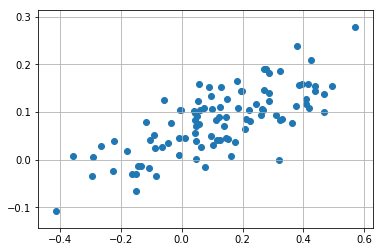

In [3]:
beta_i = 0.3
alpha_i = 0.05
E_R_M = 0.1
sigma_R_M = 0.20
sigma_e_i = 0.05
nb_tirages = 100
liste_R_M = []
liste_R_i = []

for tirage in range(nb_tirages):
    R_M = sigma_R_M * np.random.normal() + E_R_M
    R_i = alpha_i + beta_i * R_M + sigma_e_i * np.random.normal()
    liste_R_M.append(R_M)
    liste_R_i.append(R_i)

plt.scatter(liste_R_M, liste_R_i)
plt.grid(True)

Pour réaliser une régression linéaire, on va se servir du package [StatsModel](http://www.statsmodels.org/stable/index.html).

In [14]:
import statsmodels.api as sm

y = pd.DataFrame({'R_i' : liste_R_i})
X = pd.DataFrame({'R_M' : liste_R_M, 
                  'Constante' : [1] * nb_tirages})
print(X.head())
print(y.head())

model = sm.OLS(y, X).fit()
print(model.summary())

/Users/nicolasmauhe/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


NameError: name 'liste_R_i' is not defined

On peut obtenir les paramètres du modèles à l'aide de:

In [5]:
model.params

Constante    0.053086
R_M          0.240338
dtype: float64

Et un paramètre en particulier comme suit:

In [6]:
model.params['R_M']

0.2403384368363367

On peut représenter la droite estimée sur le diagramme de dispersion:

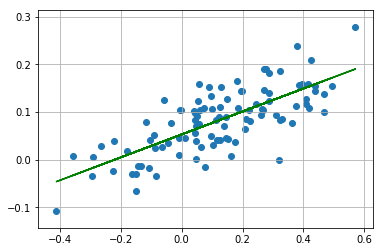

In [7]:
plt.scatter(liste_R_M, liste_R_i)
plt.plot(X['R_M'], model.params['R_M'] * X['R_M'] +  model.params['Constante'], color="Green")
plt.grid(True)

Intéressons-nous à la variance de la prime de risque notre actif i :
$$Var(R_i) = Var(\alpha_i + \beta_iR_M + e_i)$$
$$Var(r_i - r_f) = Var(\alpha_i + \beta_i(r_M - r_f) + e_i)$$
$$\sigma_i^2 = \beta_i^2\sigma_M^2 + \sigma(e_i)^2$$

On peut donc séparer la variance du surplus de rendement en variance due au marché et en variance spécifique à l'actif.

La covariance entre les rendements des deux actifs i et j est simplement :
$$Cov(r_i, r_j) = \beta_i\beta_j\sigma_M^2$$
Ce qui nous donne:
$$Corr(r_i, r_j) = \frac{\beta_i\beta_j\sigma_M^2}{\sigma_i\sigma_j} = \frac{\beta_i\sigma_M^2\beta_j\sigma_M^2}{\sigma_i\sigma_M\sigma_j\sigma_M} = Corr(r_i, r_M) * Corr(r_j, r_M)$$

Pour le moment, nous avons beaucoup moins d'estimations requises. 

Il nous faut :
- n estimations des surplus de rendement hors-marché, $\sigma_i$.
- n estimations des sensibilités de l'actif aux variations du marché, $\beta_i$
- n estimations des variances spécifiques à l'actif, $\sigma^2(e_i)$
- 1 estimation du surplus de rendement du marché, $E(R_M)$
- 1 estimation de la variance du marché $\sigma^2_M$


Soit $3n + 2$ estimations.

### Estimation de données réelles

In [2]:
import quandl
cle_API = "vV5n2kkCHA3mm-zKCwBQ"
quandl.ApiConfig.api_key = cle_API

In [39]:
debut = '2015-01-01'
frequence = 'monthly'

Pour l'index, nous choisirons le General Index fourni par le NASDAQ.

In [4]:
index = quandl.get('NASDAQOMX/NQGI', start_date = debut, column_index = 1, collapse=frequence)
index.columns = ['Index']

In [15]:
index.head()

,Index
Trade Date,
2015-01-31,1242.72
2015-02-28,1308.86
2015-03-31,1288.48
2015-04-30,1321.21
2015-05-31,1317.63


Importons les données des actions qui nous intéressent (ici Ford et Verizon).

In [16]:
liste_actions = ['WIKI/F']

In [17]:
nb_actifs = len(liste_actions)

actions = quandl.get(liste_actions, start_date = debut, column_index = 4, collapse=frequence)

In [18]:
actions.head()

,WIKI/F - Close
Date,
2015-01-31,14.71
2015-02-28,16.34
2015-03-31,16.14
2015-04-30,15.80
2015-05-31,15.17


Il nous faut également un rendement pour l'actif sans risque : nous prendrons le rendement du Treasury Bill à 4 semaines.

In [40]:
actif_sans_risque = quandl.get('USTREASURY/BILLRATES', start_date = debut, column_index = 2, collapse=frequence)
actif_sans_risque.columns = ['Actif sans risque']

In [41]:
actif_sans_risque.head()

,Actif sans risque
Date,
2017-11-30,1.14
2017-12-31,1.27
2018-01-31,1.43
2018-02-28,1.50
2018-03-31,1.70


In [42]:
actif_sans_risque = (1 + actif_sans_risque/100) ** (1/12) - 1
actif_sans_risque.tail()

,Actif sans risque
Date,
2017-11-30,0.000945
2017-12-31,0.001052
2018-01-31,0.001184
2018-02-28,0.001241
2018-03-31,0.001406


In [43]:
donnees = pd.concat([actions.pct_change(), index.pct_change(), actif_sans_risque], axis=1)

In [44]:
donnees.tail()

,WIKI/AAPL - Close,WIKI/ABC - Close,WIKI/AA - Close,WIKI/ABBV - Close,WIKI/ACE - Close,WIKI/AGN - Close,WIKI/ADP - Close,WIKI/ADSK - Close,WIKI/ABT - Close,WIKI/AEE - Close,Index,Actif sans risque
Date,,,,,,,,,,,,
2017-11-30,0.016623,0.102274,-0.131226,0.073906,NaN,-0.019184,-0.015483,-0.122119,0.039462,0.031779,0.017963,0.000945
2017-12-31,-0.015246,0.082528,0.297760,-0.002167,NaN,-0.058966,0.023851,-0.044394,0.012418,-0.077705,0.016302,0.001052
2018-01-31,-0.010636,0.085493,-0.034342,0.160376,NaN,0.101968,0.054953,0.102929,0.089189,-0.040007,0.052204,0.001184
2018-02-28,0.063848,-0.045249,-0.135525,0.032169,NaN,-0.144458,-0.066974,0.016001,-0.029440,-0.041144,-0.043097,0.001241
2018-03-31,-0.015832,-0.022699,0.030909,-0.032807,NaN,0.078135,-0.007542,0.143356,0.031991,0.016575,0.008949,0.001406


In [21]:
for i in range(nb_actifs + 1):
    donnees.iloc[:,i] = donnees.iloc[:,i] - donnees.iloc[:,-1]

In [22]:
donnees.tail()

,WIKI/F - Close,Index,Actif sans risque
Date,,,
2017-11-30,0.019430,0.017018,0.000945
2017-12-31,-0.003448,0.015250,0.001052
2018-01-31,-0.122881,0.051020,0.001184
2018-02-28,-0.034058,-0.044339,0.001241
2018-03-31,0.036295,0.007544,0.001406


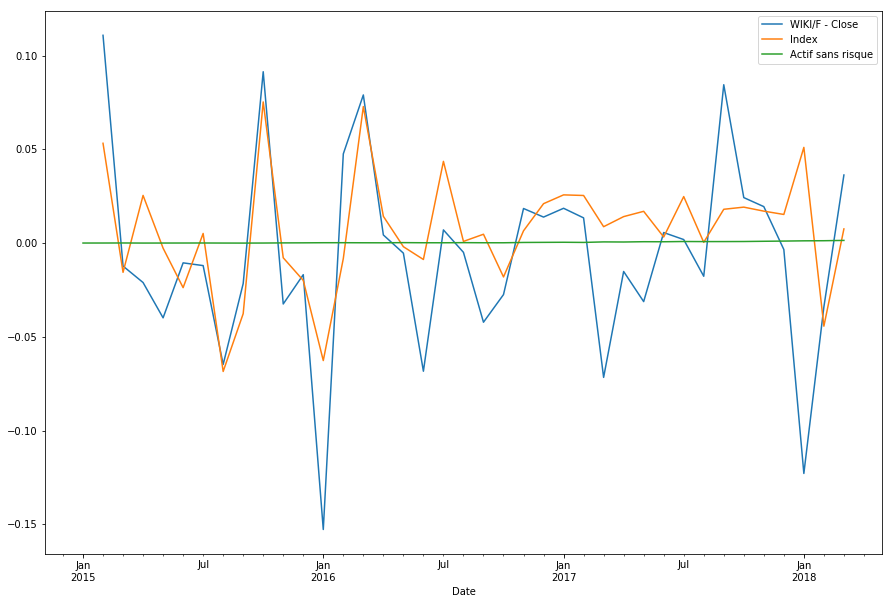

In [23]:
donnees.plot()

In [24]:
donnees = donnees.dropna(axis=0)

Pour conduire la régression, il faut simplement ajouter une constante:

In [25]:
y = donnees.iloc[:,0]
X = donnees['Index']
X = sm.add_constant(X)

In [26]:
X.head()

,const,Index
Date,,
2015-02-28,1.0,0.053205
2015-03-31,1.0,-0.015612
2015-04-30,1.0,0.025410
2015-05-31,1.0,-0.002718
2015-06-30,1.0,-0.023787


In [27]:
y.head()

Date
2015-02-28    0.110792
2015-03-31   -0.012282
2015-04-30   -0.021057
2015-05-31   -0.039882
2015-06-30   -0.010564
Freq: M, Name: WIKI/F - Close, dtype: float64

In [28]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         WIKI/F - Close   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     17.54
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           0.000173
Time:                        09:24:14   Log-Likelihood:                 66.490
No. Observations:                  38   AIC:                            -129.0
Df Residuals:                      36   BIC:                            -125.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0130      0.007     -1.807      0.0

### Plusieurs actions

Pour obtenir un grand nombre d'actions, utilisons la liste des ticker symbol de la base WIKI, disponibles dans le fichier csv [WIKI-datasets-codes.csv]().

In [31]:
fichier = open('WIKI-datasets-codes.csv', 'r')

for action in fichier:
    print(action)
    
fichier.close()

WIKI/AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and Trading Volume"

WIKI/ABC,"AmerisourceBergen Corp. (ABC) Prices, Dividends, Splits and Trading Volume"

WIKI/AA,"Alcoa Inc. (AA) Prices, Dividends, Splits and Trading Volume"

WIKI/ABBV,"AbbVie Inc. (ABBV) Prices, Dividends, Splits and Trading Volume"

WIKI/ACE,"ACE Ltd (ACE) Prices, Dividends, Splits and Trading Volume"

WIKI/AGN,"Allergan Inc. (AGN) Prices, Dividends, Splits and Trading Volume"

WIKI/ADP,"Automatic Data Processing Inc. (ADP) Prices, Dividends, Splits and Trading Volume"

WIKI/ADSK,"Autodesk Inc. (ADSK) Prices, Dividends, Splits and Trading Volume"

WIKI/ABT,"Abbott Laboratories (ABT) Prices, Dividends, Splits and Trading Volume"

WIKI/AEE,"Ameren Corp. (AEE) Prices, Dividends, Splits and Trading Volume"

WIKI/ACN,"Accenture plc (ACN) Prices, Dividends, Splits and Trading Volume"

WIKI/AEP,"American Electric Power Company (AEP) Prices, Dividends, Splits and Trading Volume"

WIKI/ADBE,"Adobe Systems Incorporated

WIKI/BLKB,"Blackbaud Inc. (BLKB) Prices, Dividends, Splits and Trading Volume"

WIKI/HAWK,"Blackhawk Network Holdings Inc (HAWK) Prices, Dividends, Splits and Trading Volume"

WIKI/BKCC,"BlackRock Capital Investment Corp (BKCC) Prices, Dividends, Splits and Trading Volume"

WIKI/BLMN,"Bloomin' Brands Inc. (BLMN) Prices, Dividends, Splits and Trading Volume"

WIKI/BLT,"Blount International Inc. (BLT) Prices, Dividends, Splits and Trading Volume"

WIKI/BCOR,"Blucora Inc. (BCOR) Prices, Dividends, Splits and Trading Volume"

WIKI/NILE,"Blue Nile Inc. (NILE) Prices, Dividends, Splits and Trading Volume"

WIKI/BLUE,"bluebird bio Inc. (BLUE) Prices, Dividends, Splits and Trading Volume"

WIKI/BXC,"BlueLinx Holdings Inc (BXC) Prices, Dividends, Splits and Trading Volume"

WIKI/BTH,"Blyth Inc (BTH) Prices, Dividends, Splits and Trading Volume"

WIKI/BNCN,"BNC Bancorp (BNCN) Prices, Dividends, Splits and Trading Volume"

WIKI/BOBE,"Bob Evans Farms Inc. (BOBE) Prices, Dividends, Splits and Tradi

WIKI/METR,"Metro Bancorp Inc (PA) (METR) Prices, Dividends, Splits and Trading Volume"

WIKI/MTD,"Mettler-Toledo International Inc. (MTD) Prices, Dividends, Splits and Trading Volume"

WIKI/MIL,"MFC Industrial Ltd. (MIL) Prices, Dividends, Splits and Trading Volume"

WIKI/MGEE,"MGE Energy Inc (MGEE) Prices, Dividends, Splits and Trading Volume"

WIKI/MTG,"MGIC Investment Corp. (MTG) Prices, Dividends, Splits and Trading Volume"

WIKI/MGM,"MGM Resorts International (MGM) Prices, Dividends, Splits and Trading Volume"

WIKI/MCRL,"Micrel Inc. (MCRL) Prices, Dividends, Splits and Trading Volume"

WIKI/MCRS,"MICROS Systems, Inc. (MCRS) Prices, Dividends, Splits and Trading Volume"

WIKI/MSCC,"Microsemi Corporation (MSCC) Prices, Dividends, Splits and Trading Volume"

WIKI/MSTR,"MicroStrategy Incorporated (MSTR) Prices, Dividends, Splits and Trading Volume"

WIKI/MBRG,"Middleburg Financial Corp. (MBRG) Prices, Dividends, Splits and Trading Volume"

WIKI/MIDD,"Middleby Corp. (MIDD) Prices, Div

On va stocker les ticker symbols dans la liste liste_actions.

In [45]:
liste_actions = []
fichier = open('WIKI-datasets-codes.csv', 'r')

for ligne in fichier:
    liste_actions.append(ligne.split(',')[0])
    
fichier.close()

print(liste_actions[0:10])
print(len(liste_actions))

['WIKI/AAPL', 'WIKI/ABC', 'WIKI/AA', 'WIKI/ABBV', 'WIKI/ACE', 'WIKI/AGN', 'WIKI/ADP', 'WIKI/ADSK', 'WIKI/ABT', 'WIKI/AEE']
3196


Reconstituons le jeu de données en utilisant les commandes vues précédemment:

In [53]:
nb_actifs = 10
liste_actions_courte = liste_actions[:nb_actifs]

In [54]:
debut = '2015-01-01'
frequence = 'monthly'

index = quandl.get('NASDAQOMX/NQGI', start_date = debut, column_index = 1, collapse=frequence)
index.columns = ['Index']

actions = quandl.get(liste_actions_courte, start_date = debut, column_index = 4, collapse=frequence)
actif_sans_risque = quandl.get('USTREASURY/BILLRATES', start_date = debut, column_index = 2, collapse=frequence)
actif_sans_risque.columns = ['Actif sans risque']
actif_sans_risque = (1 + actif_sans_risque/100) ** (1/12) - 1

donnees = pd.concat([actions.pct_change(), index.pct_change(), actif_sans_risque], axis=1)
donnees.drop(donnees.head(1).index, inplace=True)

Nettoyons les données; pour aller vite, nous allons simplement interpoler les données manquantes.

In [55]:
donnees_propres = donnees.interpolate()
donnees_propres.dropna(axis=1, how='any', inplace=True)

Il reste à soustraire le taux de l'actif sans risque:

In [56]:
for i in range(nb_actifs + 1):
    donnees.iloc[:,i] = donnees.iloc[:,i] - donnees.iloc[:,-1]

In [57]:
donnees_propres.tail()

,WIKI/AAPL - Close,WIKI/ABC - Close,WIKI/ABBV - Close,WIKI/ACE - Close,WIKI/AGN - Close,WIKI/ADP - Close,WIKI/ADSK - Close,WIKI/ABT - Close,WIKI/AEE - Close,Index,Actif sans risque
Date,,,,,,,,,,,
2017-11-30,0.016623,0.102274,0.073906,-0.049893,-0.019184,-0.015483,-0.122119,0.039462,0.031779,0.017963,0.000945
2017-12-31,-0.015246,0.082528,-0.002167,-0.049893,-0.058966,0.023851,-0.044394,0.012418,-0.077705,0.016302,0.001052
2018-01-31,-0.010636,0.085493,0.160376,-0.049893,0.101968,0.054953,0.102929,0.089189,-0.040007,0.052204,0.001184
2018-02-28,0.063848,-0.045249,0.032169,-0.049893,-0.144458,-0.066974,0.016001,-0.029440,-0.041144,-0.043097,0.001241
2018-03-31,-0.015832,-0.022699,-0.032807,-0.049893,0.078135,-0.007542,0.143356,0.031991,0.016575,0.008949,0.001406


In [60]:
nb_observations, nb_actifs = donnees_propres.shape

Lançons les régressions:

In [ ]:
resultats = pd.DataFrame(columns=['actif', 'alpha', 'beta', 'risque', 'rendement moyen'])

X = donnees['Index']
X = sm.add_constant(X)

for i in range(nb_actifs - 2):
    y = donnees_propres.iloc[:,i]
    model = sm.OLS(y, X).fit()
    resultats = resultats.append({'actif': liste_actions[i],
                                  'alpha': model.params['const'], 
                                  'beta': model.params['Index'], 
                                  'risque': np.var(model.resid),
                                  'rendement moyen' : np.mean(y)}, 
                                 ignore_index=True)

prime_marche = np.mean(donnees['Index'])
resultats = resultats.set_index('actif')

Affichons les résultats :

In [61]:
print(resultats)

              alpha      beta    risque  rendement moyen
actif                                                   
WIKI/AAPL  0.005473  1.098920  0.002950         0.012696
WIKI/ABC  -0.004711  1.031209  0.004221         0.002067
WIKI/AA    0.010440  1.240540  0.002985         0.018593
WIKI/ABBV -0.034758  0.262426  0.001299        -0.033033
WIKI/ACE  -0.016213  1.132914  0.005810        -0.008767
WIKI/AGN   0.004722  0.777516  0.001865         0.009833
WIKI/ADP   0.015304  2.131519  0.006041         0.029314
WIKI/ADSK  0.000302  1.570257  0.001434         0.010623
WIKI/ABT   0.005885  0.045488  0.001925         0.006184


Exercice : Compléter le tableau de résultats avec les écart-types.